# How to use Arrow Plots with Cartopy

In this brief notebook, I'm describing how to use matplotlib's quiver plot to make a plot of arrows.
Usually this would be done for example to plot wind directions on a map.

## Step 1: Import the necessary libraries

We need numpy to create the data, xarray because that's usually how we find the data in the wild, matplotlib to create the plot, and cartopy for the specific map plots.

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

## Step 2: Create the Data

In this case, we're creating latitude and longitude arrays, and create the two directional arrow components in such a way that they always point towards (0, 0). 
That way we can easily check whether the data is plotted correctly.

We also verify that the data is correct with a simple plot.

In [2]:
nlon, nlat = 30, 15
lon = np.linspace(-180, 180, nlon, endpoint=False)
lat = np.linspace(-90, 90, nlat, endpoint=True)
XX, YY = np.meshgrid(lon, lat)
wind_u = -XX / 100
wind_v = -YY / 100

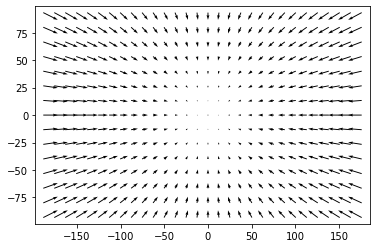

In [3]:
plt.quiver(lon, lat, wind_u, wind_v, pivot='mid')
plt.show()

## Step 3: Convert to xarray

Usually the data exists as xarray. And since there is a minor issue with xarray to be discussed later, it's a good idea to convert the data to an xarray Dataset.

In [4]:
lon = xr.DataArray(lon, dims=('lon',), coords={'lon': lon}, attrs={'units': 'degree east'})
lat = xr.DataArray(lat, dims=('lat',), coords={'lat': lat}, attrs={'units': 'degree north'})

In [5]:
wind_u = xr.DataArray(
    wind_u, 
    dims=('lat', 'lon'), 
    coords={'lon': lon, 'lat': lat}, 
    attrs={'units': 'm/s', 'long_name': 'U component of wind'}
)
wind_v = xr.DataArray(
    wind_v, 
    dims=('lat', 'lon'), 
    coords={'lon': lon, 'lat': lat}, 
    attrs={'units': 'm/s', 'long_name': 'V component of wind'}
)
ds = xr.Dataset({'wind_u': wind_u, 'wind_v': wind_v})

## Step 4a: Initial Plot

Initially it looks as if we could plot the dataset right from the go:

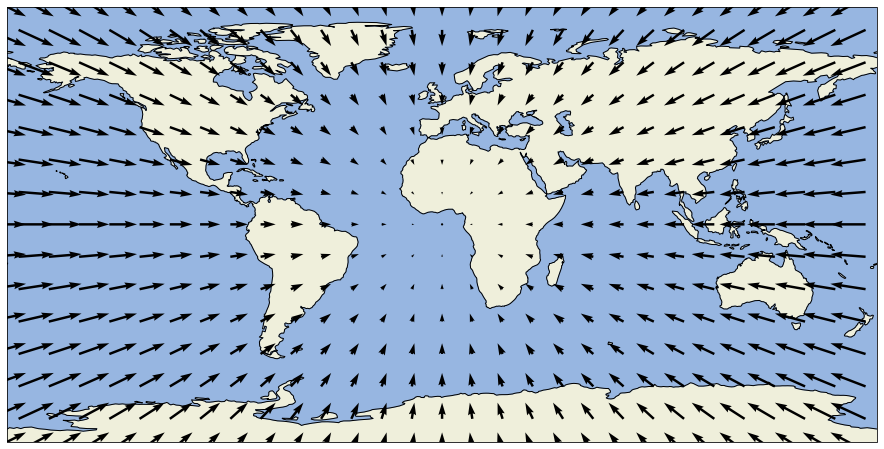

In [6]:
fig, ax = plt.subplots(figsize=(16, 8), subplot_kw={'projection': ccrs.PlateCarree()})
ax.coastlines()
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.quiver(ds['lon'], ds['lat'], ds['wind_u'], ds['wind_v'], pivot='mid', transform=ccrs.PlateCarree())
plt.show()

But for some reason, the plot falls down when the projection gets a little more complicated:

TypeError: Argument 'x' has incorrect type (expected numpy.ndarray, got DataArray)

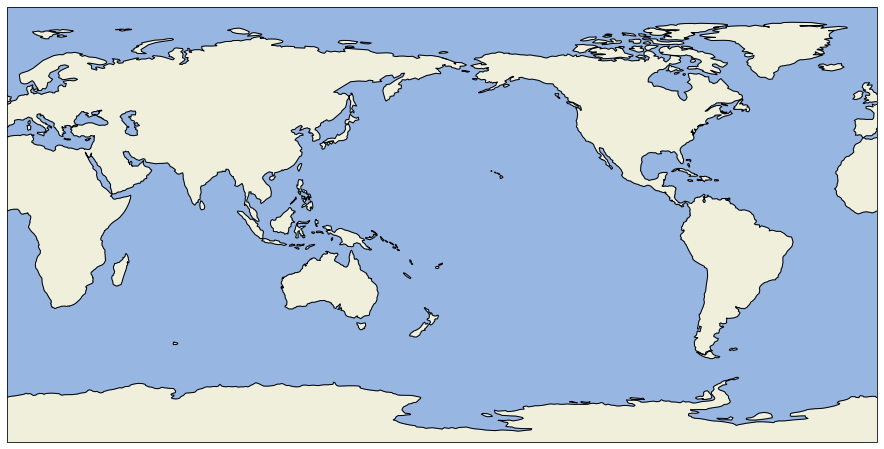

In [7]:
fig, ax = plt.subplots(figsize=(16, 8), 
                       subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})
ax.coastlines()
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.quiver(ds['lon'], ds['lat'], ds['wind_u'], ds['wind_v'], pivot='mid', 
          transform=ccrs.PlateCarree())
plt.show()

## Step 4b: For plotting, extract the values as numpy arrays

I don't know whether it's cartopy or quiver which is causing this issue. Apparently they're not working well with xarray.

The workaround is to extract the numpy arrays from the DataArrays using the `values` attribute:

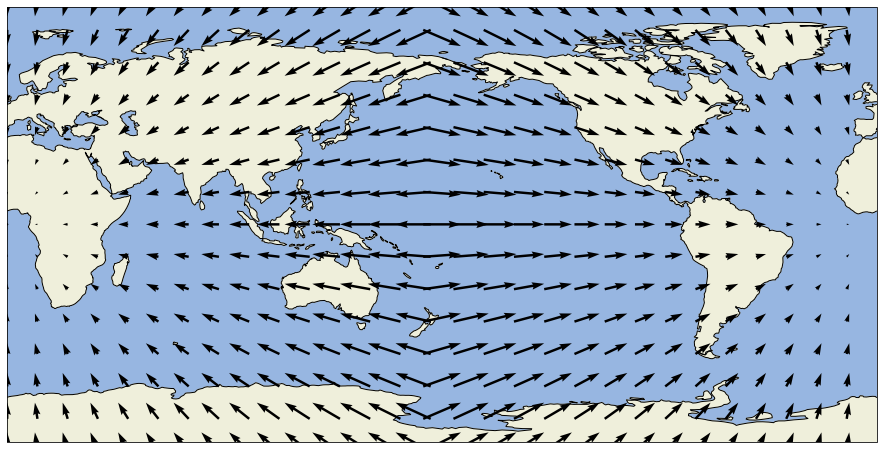

In [8]:
fig, ax = plt.subplots(figsize=(16, 8), 
          subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)}
)
ax.coastlines()
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.LAND)
ax.quiver(ds['lon'].values, ds['lat'].values, ds['wind_u'].values, ds['wind_v'].values, 
          pivot='mid',
          transform=ccrs.PlateCarree()
)
plt.show()

If we zoom into a region of the map, for example South America, we can verify that the arrows are still pointing towards [Null Island](https://en.wikipedia.org/wiki/Null_Island)

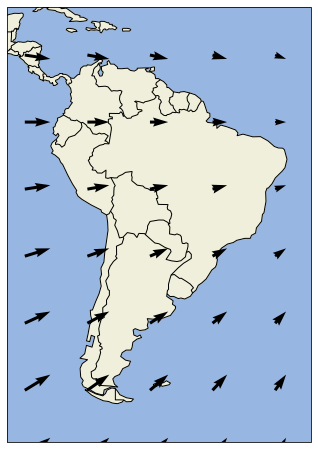

In [9]:
fig, ax = plt.subplots(figsize=(16, 8), 
          subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)}
)
ax.coastlines()
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.BORDERS)
ax.set_extent([-90, -30, -60, 20])
ax.quiver(ds['lon'].values, ds['lat'].values, ds['wind_u'].values, ds['wind_v'].values, 
          pivot='mid', scale=10, width=0.01,
          transform=ccrs.PlateCarree()
)
plt.show()